In [156]:
import os
import json
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

%matplotlib inline

import lightgbm as lgb
from lightgbm import early_stopping
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from datetime import datetime

# 1. 데이터셋 load

In [157]:
# 파일 경로 설정
train_path = '/Volumes/Expansion/google_analytics_customer/train.csv'
test_path = '/Volumes/Expansion/google_analytics_customer/test.csv'

# 데이터 로딩 함수 정의
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'})

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {csv_path.split('/')[-1]}. Shape: {df.shape}")
    return df

# 데이터 로딩
train_df = load_df(train_path)
test_df = load_df(test_path)

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


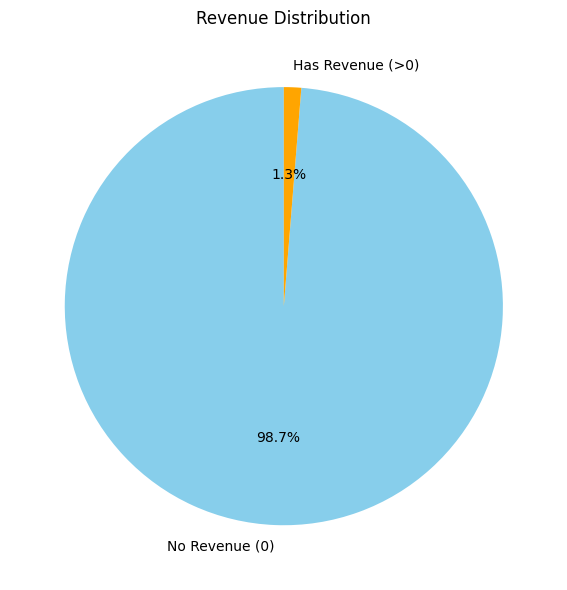

In [150]:
df = train_df.copy()

# 복사본에서 0과 0이 아닌 값 구분
df['revenue_flag'] = df['totals.transactionRevenue'].fillna(0).astype(float)
df['revenue_flag'] = df['revenue_flag'].apply(lambda x: 0 if x == 0 else 1)

# 카운트
revenue_counts = df['revenue_flag'].value_counts().sort_index()
labels = ['No Revenue (0)', 'Has Revenue (>0)']

# 시각화
plt.figure(figsize=(6,6))
plt.pie(revenue_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Revenue Distribution')
plt.tight_layout()
plt.show()

In [ ]:
# 수익 컬럼을 float형으로 변환 (NaN은 0으로)
df['revenue'] = df['totals.transactionRevenue'].fillna(0).astype(float)

# 0이 아닌 값만 추출
non_zero_revenue = df[df['revenue'] > 0]['revenue']

# 최대값, 최소값, 차이 출력
max_val = non_zero_revenue.max()
min_val = non_zero_revenue.min()
difference = max_val - min_val

print(f"최고 수익값: {max_val:,.0f}")
print(f"최저 수익값: {min_val:,.0f}")
print(f"최고-최저 수익 차이: {difference:,.0f}")

최고 수익값: 23,129,500,000
최저 수익값: 10,000
최고-최저 수익 차이: 23,129,490,000


In [158]:
# 타겟 설정
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0).astype(float)
train_y = np.log1p(train_df['totals.transactionRevenue'])

del train_df['totals.transactionRevenue']

# 2. 데이터 전처리
## 1) 컬럼 제거

### (1) Constant value를 갖는 컬럼 제거 + 결측치 처리
- 모든 행이 같은 값을 가지고 있는 컬럼 조회

In [159]:
# 고정값 컬럼 제거
const_cols = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(columns=const_cols, inplace=True)
test_df.drop(columns=[col for col in const_cols if col in test_df.columns], inplace=True)

print("train_df length : ", len(train_df.columns))
print("test_df length : ", len(test_df.columns))


# 일부 컬럼 NaN 처리
na_fill_dict = {
    'totals.bounces': '0',
    'totals.newVisits': '0',
    'trafficSource.adwordsClickInfo.isVideoAd': True,
    'trafficSource.isTrueDirect': False
}

for col, fill_val in na_fill_dict.items():
    train_df[col] = train_df[col].fillna(fill_val)
    test_df[col] = test_df[col].fillna(fill_val)

train_df length :  35
test_df length :  34


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_30051/3483537690.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df[col] = train_df[col].fillna(fill_val)
/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_30051/3483537690.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[col] = test_df[col].fillna(fill_val)


In [160]:
# 공통 컬럼만 남기기
common_cols = [col for col in train_df.columns if col in test_df.columns and train_df[col].nunique() > 1]
train_df = train_df[common_cols]
test_df = test_df[common_cols]

print("train_df length : ", len(train_df.columns))
print("test_df length : ", len(test_df.columns))

train_df length :  34
test_df length :  34


### (2) feature engineering

In [161]:
# 데이터 병합 후 피처 엔지니어링
trn_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df])

merged_df['diff_visitId_time'] = merged_df['visitId'] - merged_df['visitStartTime']
merged_df['diff_visitId_time'] = (merged_df['diff_visitId_time'] != 0).astype(int)
del merged_df['visitId']

if 'sessionId' in merged_df.columns:
    del merged_df['sessionId']

merged_df['formated_date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
merged_df['month'] = merged_df['formated_date'].dt.month
merged_df['quarter_month'] = merged_df['formated_date'].dt.day // 8
merged_df['day'] = merged_df['formated_date'].dt.day
merged_df['weekday'] = merged_df['formated_date'].dt.weekday

# 일별 평균 hits
merged_df['totals.hits'] = merged_df['totals.hits'].astype(int)
merged_df['mean_hits_per_day'] = merged_df.groupby(['day'])['totals.hits'].transform('mean')
del merged_df['day']

# 방문 시간 시각화
merged_df['formated_visitStartTime'] = pd.to_datetime(
    merged_df['visitStartTime'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))))
merged_df['visit_hour'] = merged_df['formated_visitStartTime'].dt.hour

# 불필요한 컬럼 제거
del merged_df['date']
del merged_df['formated_date']
del merged_df['visitStartTime']
del merged_df['formated_visitStartTime']

In [162]:
merged_df.columns

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.bounces', 'totals.newVisits', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent',
       'diff_visitId_time', 'month', 'quarter_month', 'weekday',
       'mean_hits_per_day', 'visit_hour'],
      dtype='object')

### (3) label encoding

In [163]:
# 레이블 인코딩
for col in merged_df.columns:
    if col in ['fullVisitorId', 'month', 'quarter_month', 'weekday', 'visit_hour']:
        continue
    if merged_df[col].dtype == object or merged_df[col].dtype == bool:
        merged_df[col], _ = pd.factorize(merged_df[col])

# 범주형/수치형 분리
numerics = [col for col in merged_df.columns if 'totals.' in col]
numerics += ['visitNumber', 'mean_hits_per_day', 'fullVisitorId']
categorical_feats = [col for col in merged_df.columns if col not in numerics]

for col in categorical_feats:
    merged_df[col] = merged_df[col].astype(int)

### (4) train/valid/test 분리

In [164]:
# train/test 분리
train_df = merged_df[:trn_len]
test_df = merged_df[trn_len:]

train_X = train_df.drop(['fullVisitorId'], axis=1)
test_X = test_df.drop(['fullVisitorId'], axis=1)

# 훈련/검증 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# 3. 모델 훈련

### (1) LightGBM 훈련
- 교차검증을 통한 파라미터 최적화

In [166]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer

# RMSLE 정의
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(np.maximum(0, y_pred))))

# Scorer로 사용
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# LGBM 모델
model = lgb.LGBMRegressor(objective='regression', verbosity=-1)

# 파라미터 그리드 설정
param_grid = {
    'num_leaves': [31, 50, 100, 200],
    'min_child_samples': [20, 50, 100],
    'learning_rate': [0.1, 0.05, 0.001],
    'n_estimators': [100, 200, 500]
}

# 교차검증 방식
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=kf,
    verbose=1,
    n_jobs=-1
)

# 학습 데이터 사용
grid_search.fit(train_X, train_y)

# 결과 출력
print("Best Parameters: ", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/taeheon/miniforge3/envs/customer/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters:  {'learning_rate': 0.001, 'min_child_samples': 100, 'n_estimators': 500, 'num_leaves': 200}


### (2) 예측 결과 시각화

In [167]:
def evaluate_model(pred_val, y_valid, valid_df):
    # 음수 예측 제거
    pred_val[pred_val < 0] = 0

    # 예측 및 실제 수익 복원 (로그 원복)
    val_pred_df = pd.DataFrame()
    val_pred_df["fullVisitorId"] = valid_df["fullVisitorId"].values
    val_pred_df["transactionRevenue"] = np.expm1(y_valid)
    val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

    # 사용자 단위 집계
    val_pred_df = val_pred_df.groupby("fullVisitorId")[["transactionRevenue", "PredictedRevenue"]].sum().reset_index()

    # 로그 변환 및 에러 계산
    val_pred_df["log_true"] = np.log1p(val_pred_df["transactionRevenue"])
    val_pred_df["log_pred"] = np.log1p(val_pred_df["PredictedRevenue"])
    val_pred_df["error"] = val_pred_df["log_true"] - val_pred_df["log_pred"]

    # 평가 지표 출력
    print("Evaluation Metrics (Manual RMSLE)")
    print("RMSLE :", np.sqrt(metrics.mean_squared_error(val_pred_df['log_true'], val_pred_df['log_pred'])))
    print("RMSE  :", np.sqrt(metrics.mean_squared_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue'])))
    print("MAE   :", metrics.mean_absolute_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue']))
    print("R²    :", metrics.r2_score(val_pred_df['log_true'], val_pred_df['log_pred']))

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. 실제 vs 예측 수익 (Log Scaled)
    sns.scatterplot(data=val_pred_df, x='transactionRevenue', y='PredictedRevenue', ax=axes[0, 0], alpha=0.4)
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Actual vs Predicted Revenue (Log Scaled)')
    axes[0, 0].set_xlabel('Actual Revenue')
    axes[0, 0].set_ylabel('Predicted Revenue')

    # 2. 에러 분포 (로그 에러)
    sns.histplot(val_pred_df["error"], bins=50, kde=True, ax=axes[0, 1], color="orange")
    axes[0, 1].set_title("Log Prediction Error Distribution")
    axes[0, 1].set_xlabel("Log Error")
    axes[0, 1].set_ylabel("Count")

    # 3. 잔차 vs 예측값
    sns.scatterplot(x="log_pred", y="error", data=val_pred_df, ax=axes[1, 0], alpha=0.4)
    axes[1, 0].axhline(0, linestyle="--", color="gray")
    axes[1, 0].set_title("Residuals vs Predicted Log Revenue")
    axes[1, 0].set_xlabel("Predicted Log Revenue")
    axes[1, 0].set_ylabel("Residual (Log True - Log Pred)")

    # 4. 예측 수익 분포
    sns.histplot(val_pred_df["PredictedRevenue"], bins=50, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title("Predicted Revenue Distribution")
    axes[1, 1].set_xlabel("Predicted Revenue")
    axes[1, 1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


Evaluation Metrics (Manual RMSLE)
RMSLE : 1.5396262797095444
RMSE  : 13634267.521996962
MAE   : 333739.0132504141
R²    : -1.7050393227466127


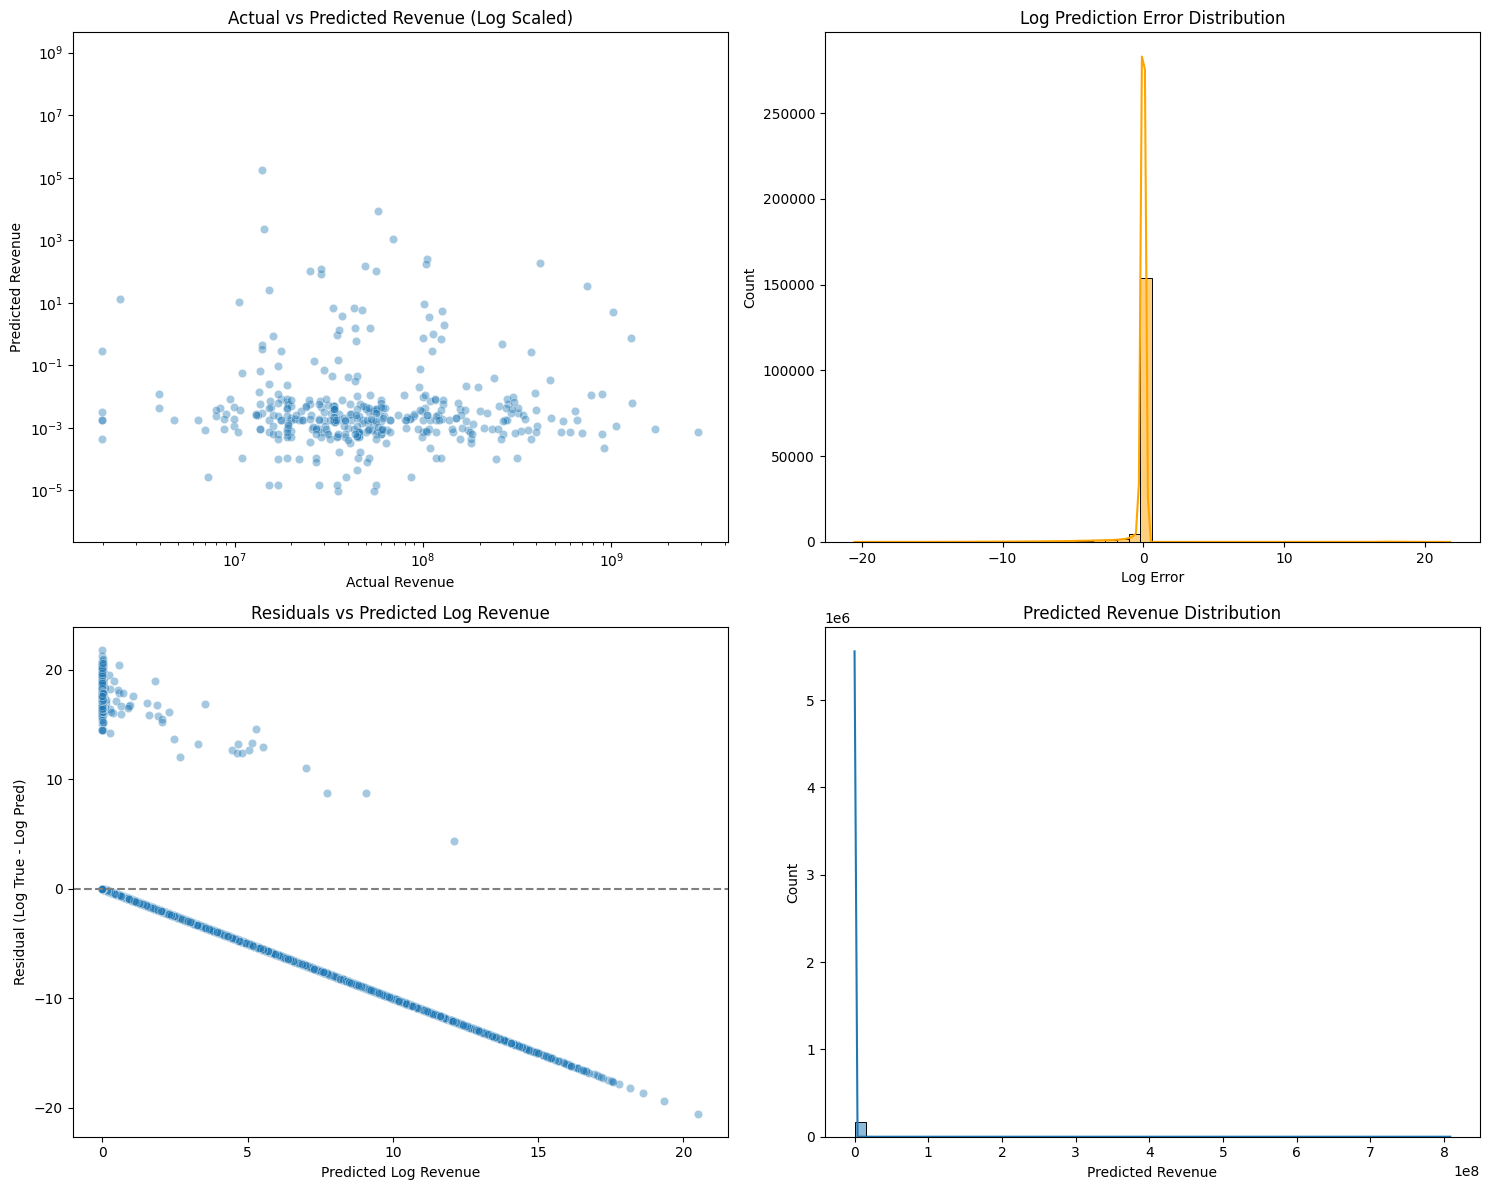

In [ ]:
# 평가용 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
best_model = grid_search.best_estimator_
pred_val = best_model.predict(X_valid)

evaluate_model(pred_val, y_valid, train_df.iloc[X_valid.index])

### (3) feature importance

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_30051/1567741368.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


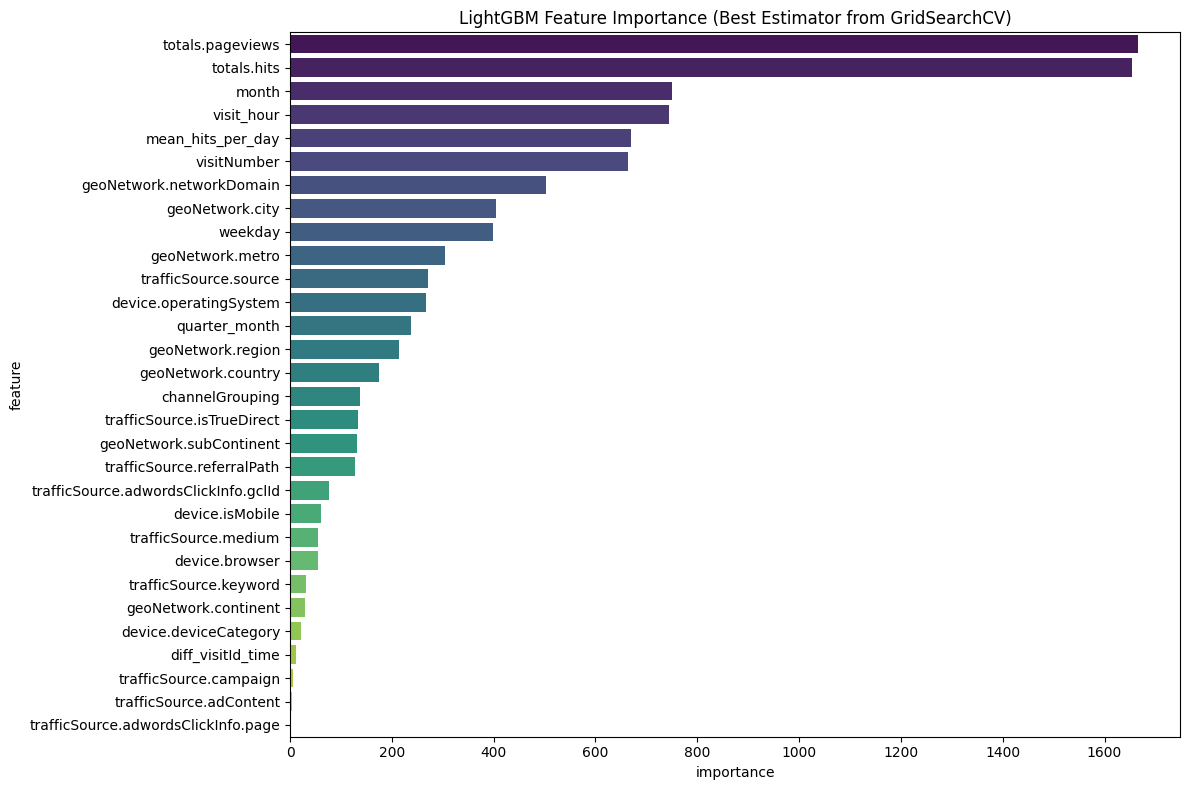

In [168]:
# feature importance 추출
feature_importance_df = pd.DataFrame({
    'feature': best_model.feature_name_,
    'importance': best_model.feature_importances_
})

# 중요도 상위 30개만 시각화
top_n = 30
top_features = feature_importance_df.sort_values(by="importance", ascending=False).head(top_n)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_features,
    x="importance", y="feature", palette="viridis"
)
plt.title("LightGBM Feature Importance (Best Estimator from GridSearchCV)")
plt.tight_layout()
plt.show()
